# Трассировка лучей


## Подключаем библиотеки и описываем вспомогательные функции

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

pi = np.arcsin(1)*2
eps = 2**(-10)
tiny_eps = 2**(-15)
min_significance = 0.01

class empty():
    def __init__(self):
        return None
    
class endles_none:
    def __init__(self, n):
        self.n = n
        return None
    def __iter__(self):
        return endles_none(self.n)
    def __next__(self):
        if self.n <= 0:
            raise StopIteration
        else:
            self.n -= 1
        return None
    
def none_func(n):
    def function(*args, **kwargs):
        if n > 1:
            return endles_none(n)
        elif n == 1:
            return None
        else:
            raise ValueError
    return function

def const_func(const):
    def function(*args, **kwargs):
        return const
    return function

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

def V3_gradient(func, point):
    x = np.array([1.,0,0])
    y = np.array([0,1.,0])
    z = np.array([0,0,1.])
    return np.array([(func(point+eps*x) - func(point-eps*x))/(2*eps),
                     (func(point+eps*y) - func(point-eps*y))/(2*eps),
                     (func(point+eps*z) - func(point-eps*z))/(2*eps)])
    

## Материалы

In [134]:
def RGB(R, G, B, base=255):
    return np.array([R/base, G/base, B/base])

#Cook-Torrance
def G(L, V, N, H):
    ans = min(np.sum(N*V), np.sum(N*L))
    ans = 2*ans*np.sum(N*H)/np.sum(H*V)
    return min(1, ans)

def D(N, H, m):
    cos_2 = np.sum(N*H)**2
    ans = np.exp(-(1-cos_2)/(m*m*cos_2))
    return ans/((2*m*(np.sum(N*H)**2))**2)

def F(f0, cos_):
    return f0 + (1-f0)*((1-cos_)**5)

# m - среднеквадратичное откланение граней
# eta - коэфицент преломления
def create_Cook_Torrance_function(m, eta):
    f0 = ((eta-1)/(eta+1))**2
    def specular_func(light, ray, normal):
        H = normalize(light - ray)
        numerator = F(f0, np.sum(-ray*normal))*D(normal, H, m)*G(light, -ray, normal, H)
        denominator = 4 * np.sum(normal*light) * np.sum(-ray*normal)
        return numerator/denominator
    return specular_func


## Алгоритмы отрисовки и трассировки

In [210]:
def render_image (camera, scene, screen, *, status = 5, depth=5):
    w = screen.w
    h = screen.h
    
    image = np.zeros((h, w, 3))
    
    # ----- status output -----
    procents = 0
    if 0 < status <= 100:
        print(0,'%')
        start_t = time.time()
        last_t = start_t
        
    for i in range(h):
        for k in range(w):
            pixel_pos = camera.position + camera.orientate + camera.delta*(camera.dx*(k - w/2) + camera.dy*(h/2 - i))
            ray = normalize(pixel_pos - camera.position)
            
            image[i][k] = trace_ray(scene, pixel_pos, ray, depth)
        
        # ----- status output -----
        if 0 < status <= 100:
            if procents < ((i/h)*100) // status:
                tmp = time.time()
                print(i/h*100,'% dt -', tmp - last_t)
                last_t = tmp
                procents = ((i/h)*100) // status
    # ----- status output -----
    if 0 < status <= 100:
        end_t = time.time()
        print(100,'% time -', end_t - start_t)
    
    return image

def trace_ray (scene, start, ray, depth=5, significance=1, weight=1):
    if (depth <= 0) or (weight < min_significance):
        return scene.ambience_light

    light = np.array([-12.0, 8, -7.0])
    
    color = np.ones((3))
    alpha = 0.4
    normal, dist, obj = scene.get_normal(start, ray)
    if normal is not None:
        ans = np.zeros(3)
        point = start + ray*dist
        color = obj.get_color(point)
        mirror = obj.get_mirror(point)
        diffuse = obj.get_diffuse(point)
            
        tmp = np.sum(normalize(light-point) * normal)
        if tmp < 0:
            tmp *= -1
        _, light_dist, _ = scene.get_normal(point + normalize(light-point)*eps, normalize(light-point))
        if light_dist >= np.linalg.norm(light-point):
            ans += color * tmp * diffuse
            specular = obj.get_specular(normalize(light-point), ray, normal)
            ans += RGB(1,1,1,1)*specular

        if mirror > 0:
            ray -= 2*normal*np.sum(normal*ray)
            ray = normalize(ray)
            ans += mirror * trace_ray(scene, point + eps*ray, ray, depth-1, 1, weight*mirror)

    else:
      ans = scene.distant_color(start, ray)
    return ans

## Описание объектов сцены

In [92]:
class render_object:
    def __init__(self, *args, **kwargs):
        if 'normal' in kwargs.keys():
            self.get_normal = kwargs['normal']
        if 'color' in kwargs.keys():
            self.get_color = kwargs['color']
        if 'specular' in kwargs.keys():
            self.get_specular = kwargs['specular']
        if 'diffuse' in kwargs.keys():
            self.get_diffuse = kwargs['diffuse']
        if 'mirror' in kwargs.keys():
            self.get_mirror = kwargs['mirror']
        return None

class scene:
    def __init__(self, render_objects, distant_color_func,ambience_color=np.zeros(3)):
        self.objects = render_objects
        self.last_object = None
        self.ambience_light = ambience_color
        self.distant_color = distant_color_func
        return None
    
    def get_normal(self, start, ray):
        normal = None
        distance = np.inf
        curent_obj = None
        for obj in self.objects:
            tmp_normal, tmp_distance = obj.get_normal(start, ray, distance)
            if tmp_distance < distance:
                distance = tmp_distance
                normal = tmp_normal
                curent_obj = obj
        return normal, distance, curent_obj

def sphere(Position, R):
    def normal(start, ray, *args):
        a = np.dot(ray, ray)
        PS = start - Position
        b = 2 * np.dot(ray, PS)
        c = np.dot(PS, PS) - R * R
        disc = b * b - 4 * a * c
        if disc > 0:
            distSqrt = np.sqrt(disc)
            q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
            t0 = q / a
            t1 = c / q
            t0, t1 = min(t0, t1), max(t0, t1)
            if t1 >= 0:
                if t0 < 0:
                    return normalize(start + ray*t1 - Position), t1
                else:
                    return normalize(start + ray*t0 - Position), t0
        return None, np.inf
    return normal

def plane(Position, Direction):
    Direction = normalize(Direction)
    def normal(start, ray, *args):
        if np.sum((Position - start) * Direction) * np.sum(ray * Direction) <= 0:
            return None, np.inf
        else:
            return Direction, np.sum((Position - start) * Direction)/np.sum(ray * Direction)
    return normal

### Описание SDF с потдержкой CSG и преобразования SDF в объкты

In [287]:
class SDF_function:
    def __init__(self, func, gradient=None):
        self.distance = func
        if gradient is not None:
            def grad(*args, **kwargs):
                return gradient(func, *args, **kwargs)
            self.gradient = grad
        return None
    
    def add_gradient(self, gradient=None):
        def grad(*args, **kwargs):
            return gradient(self.distance, *args, **kwargs)
        self.gradient = grad
        return self
    
    def __call__(self, *args, **kwargs):
        return self.distance(*args, **kwargs)
    
    def __add__(self, other):
        def func(*args, **kwargs):
            return min(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __mul__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __sub__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), -other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __neg__(self):
        def func(*args, **kwargs):
            return -self.distance(*args, **kwargs)
        return SDF_function(func)
    
    def smooth(self, other, alpha=0):
        def func(*args, **kwargs):
            return smooth_max(self.distance(*args, **kwargs), other.distance(*args, **kwargs), alpha)
        return SDF_function(func)
    
def smooth_SDF(funcs, alpha, **kwargs):
    def func(*args, **kwargs):
        numerator = 0
        denominator = 0
        for f in funcs:
            x = f(*args, **kwargs)
            numerator += x*np.exp(alpha*x)
            denominator += np.exp(alpha*x)
        return numerator/denominator
    return SDF_function(func, **kwargs)

def object_from_SDF(sdf, *args, delta=0.90, **kwargs):
    def normal(start, ray, best=np.inf):
        point = np.copy(start)
        tmp = abs(sdf(point))
        if (tmp > best):
            return None, np.inf
        prev = 0
        while (tmp < 1/tiny_eps) and (np.sum((point - start)*ray) < best):
            point += ray*delta*tmp
            prev = tmp
            tmp = abs(sdf(point))
            if (tmp <= tiny_eps) and (tmp <= prev):
                if (np.sum((point - start)*ray) > 0):
                    return normalize(sdf.gradient(point)), np.sum((point - start)*ray)
                else:
                    break
        return None, np.inf
    return render_object(*args, normal=normal, **kwargs)

## Задание сцены

In [309]:
'''
    ^ y
    |
    |
    |
    o--------> x
   /
  /
 /
L z
'''
def S1(x):
    return np.linalg.norm(x-np.array([13,4,-5])) - 4
def S2(x):
    return np.linalg.norm(x-np.array([14,6,6])) - 6
def S3(x):
    return np.linalg.norm(x-np.array([18,6.5,-1])) - 6.5
@SDF_function
def S4(x):
    return np.linalg.norm(x-np.array([11,6.5,-1])) - 4
@SDF_function
def S5(x):
    return np.linalg.norm(x-np.array([15,3,-1])) - 6
@SDF_function
def S6(x):
    return np.linalg.norm(x-np.array([10,3,-6])) - 8
@SDF_function
def S7(x):
    return np.linalg.norm(x-np.array([16,3,0])) - 3
@SDF_function
def P1(x):
    nn = normalize(np.array([-4.0,-0.1,-1.0]))
    return np.sum((x-np.array([20,13,9]))*nn)

plastic_spec = create_Cook_Torrance_function(0.4, 4)
metal_spec = create_Cook_Torrance_function(0.07, 10)
plane_spec = create_Cook_Torrance_function(0.2, 1.25)

def some_color(point):
    p = point - np.array([13,5,9])
    return RGB(255, 201, 242)*np.cos(0.5*p) + RGB(200, 231, 255)*(1 - np.cos(0.5*p))

objs = np.array([
    #render_object(normal=sphere(np.array([11,2.5,-7]), 2.5), mirror=const_func(0.7), color=const_func(RGB(1,1,0,1)), diffuse=const_func(0.3),specular=metal_spec),
    #render_object(normal=sphere(np.array([13,5,9]), 5), mirror=const_func(0.1), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec),
    #render_object(normal = sphere(np.array([17,5,-1]), 5)),
    #render_object(normal = sphere(np.array([13,4,-5]), 4)),
    #render_object(normal = sphere(np.array([14,6,6]), 6)),
    #render_object(normal = sphere(np.array([18,6.5,-1]), 6.5)),
    #render_object(normal = plane(np.array([20,13,9]), np.array([-4.0,-0.1,-1.0]))),
    #render_object(normal = plane(np.array([20,13,9]), np.array([-4.0,-5.0,-1.0]))),
    render_object(normal=sphere(np.array([11,6.5,-1]), 4), mirror=const_func(0.7), color=const_func(RGB(2,1,2,2)), diffuse=const_func(0.3),specular=metal_spec),
    render_object(normal=plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])), mirror=const_func(0.25), color=const_func(np.array([1,1,1])), diffuse=const_func(0.75), specular=plane_spec),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([15,2.5,-5])) - 2.5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([13,5,6])) - 5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([17,5,-1])) - 5, V3_gradient)),
    #object_from_SDF(smooth_SDF([S1,S2,S3], -1, gradient = V3_gradient)),
    #object_from_SDF(P1.add_gradient(V3_gradient), mirror=const_func(0), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec),
    #object_from_SDF((smooth_SDF([S1,S2,S3], -1) - S4).add_gradient(V3_gradient), mirror=const_func(0.1), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec),
    object_from_SDF((smooth_SDF([S1,S2,S3], -1).smooth(-S4, 0.2)).add_gradient(V3_gradient), delta=0.75, mirror=const_func(0.7), color=const_func(RGB(1,1,0,1)), diffuse=const_func(0.3),specular=metal_spec),
    #object_from_SDF(((S5 - S6).smooth(S7, 1.25)).add_gradient(V3_gradient), mirror=const_func(0), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec)
])

def ambient_collor(start, ray):
    high = (np.sum(ray*normalize(np.array([0.1,1,-0.3]))) + 1)/2
    return high*RGB(117, 187, 253) + (1-high)*RGB(243, 148, 98)

my_scene = scene(objs, ambient_collor, RGB(17, 15, 11)) #np.array([0.49,0.72,0.97])

## Описание камеры

In [312]:
my_camera = empty()
my_camera.position = np.array([-2.0, 5.1, 1.5])
my_camera.orientate = np.array([0.1, 0, 0])
my_camera.dx = np.array([0.0, 0.0, 1.0])
my_camera.dy = np.array([0.0, 1.0, 0.0])
my_camera.delta = 0.00085

camera_screen = empty()
camera_screen.w = 300
camera_screen.h = 179

'''my_camera.delta = 0.00425
camera_screen = empty()
camera_screen.w = 60
camera_screen.h = 34'''

'''my_camera.delta = 0.0085
camera_screen = empty()
camera_screen.w = 30
camera_screen.h = 17'''

'my_camera.delta = 0.0085\ncamera_screen = empty()\ncamera_screen.w = 30\ncamera_screen.h = 17'

## Просчитываем сцену

0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


5.027932960893855 % dt - 3.782611131668091
10.05586592178771 % dt - 3.8362412452697754
15.083798882681565 % dt - 7.331567764282227
20.11173184357542 % dt - 11.16294240951538
25.139664804469277 % dt - 11.315176248550415
30.16759776536313 % dt - 10.926302909851074
35.19553072625698 % dt - 11.426414966583252
40.22346368715084 % dt - 12.812959671020508
45.2513966480447 % dt - 13.914419412612915
50.27932960893855 % dt - 15.434505462646484
55.3072625698324 % dt - 18.25494956970215
60.33519553072626 % dt - 24.063130855560303
65.36312849162012 % dt - 30.50995397567749
70.39106145251397 % dt - 32.6508629322052
75.41899441340783 % dt - 40.79902791976929
80.44692737430168 % dt - 41.960801124572754
85.47486033519553 % dt - 32.11203861236572
90.5027932960894 % dt - 29.49030041694641
95.53072625698324 % dt - 26.920787811279297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100 % time - 395.83091259002686


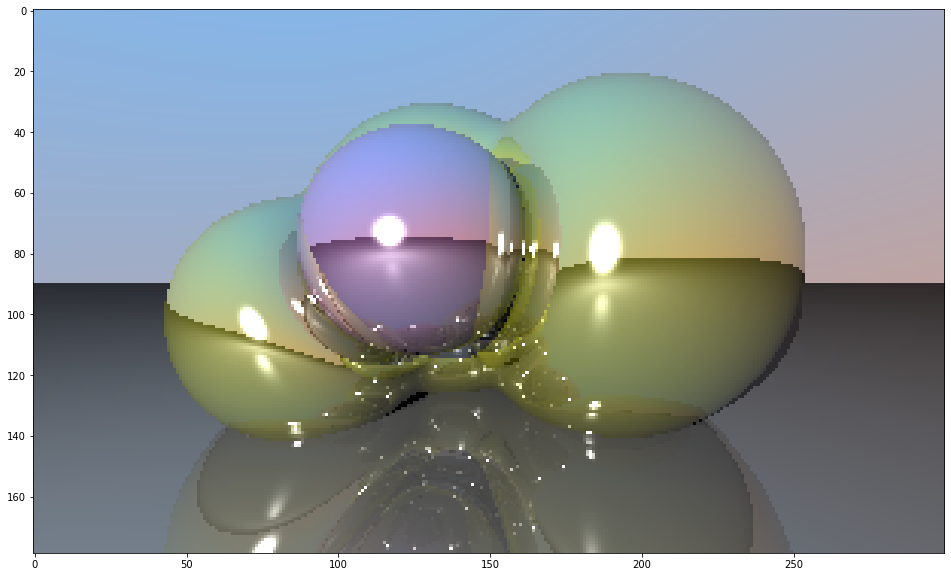

In [313]:
img = render_image(my_camera, my_scene, camera_screen, depth = 10)

#plt.imsave('tmp.png', img)
plt.figure(figsize=(20,10))
plt.imshow(img)

### Немного кода для теста

In [ ]:
tmpa = SDF_function(lambda x,y : ((x+1)*(x+1)+(y-1)*(y-1))**(0.5)-1.4)
tmpb = SDF_function(lambda x,y : ((x+1)*(x+1)+(y+1)*(y+1))**(0.5)-1.4)
tmpc = SDF_function(lambda x,y : ((x-1)*(x-1)+(y-1)*(y-1))**(0.5)-1.4)
tmpd = SDF_function(lambda x,y : ((x-1)*(x-1)+(y+1)*(y+1))**(0.5)-1.4)
tmp4 = tmpa + tmpb + tmpc + tmpd
tmp4 = smooth_SDF([tmpa, tmpb, tmpc, tmpd], -1)

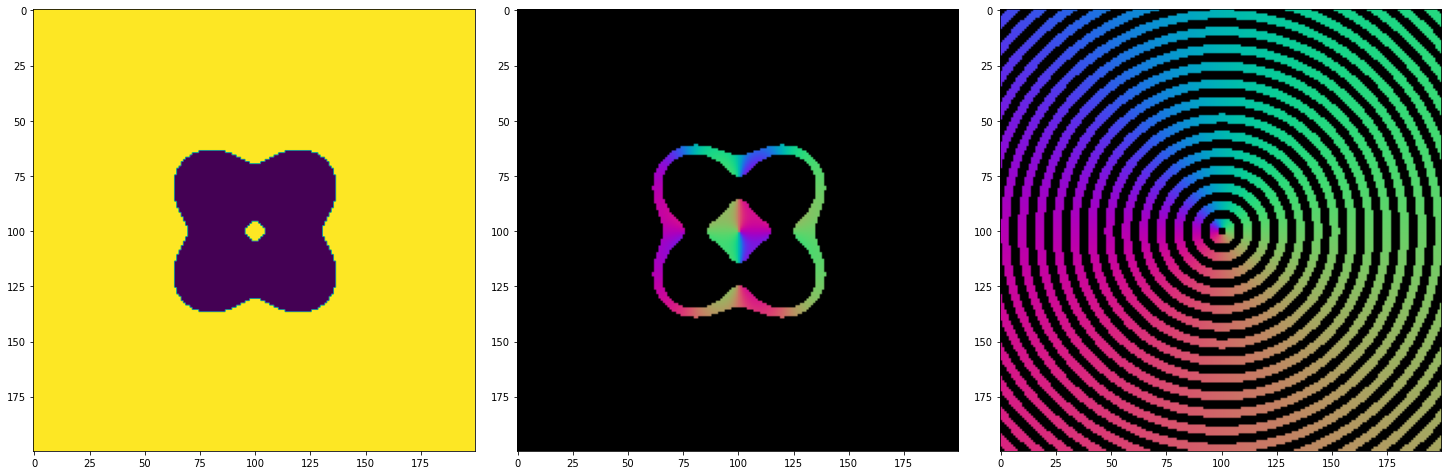

In [ ]:
import matplotlib.gridspec as gridspec
scale = 20
t_img = np.zeros((10*scale, 10*scale))
tmp_img = np.zeros((10*scale, 10*scale, 3))
dir_img = np.zeros((10*scale, 10*scale, 3))
for i in range(10*scale):
    for k in range(10*scale):
        x = i/scale - 5
        y = k/scale - 5
        if tmp4(x, y) > 0:
            t_img[i][k] = 1
        else:
            t_img[i][k] = -1
        if  -0.1 < tmp4(x, y) < 0.1:
            tmp_img[i][k][0] = (tmp4(x+tiny_eps,y)-tmp4(x-eps,y))/(2*eps)
            tmp_img[i][k][1] = (tmp4(x,y+eps)-tmp4(x,y-eps))/(2*eps)
            tmp_img[i][k] = np.ones(3) + normalize(tmp_img[i][k])
            tmp_img[i][k] = normalize(tmp_img[i][k])
        if -0.707 < np.cos(8*(x*x+y*y)**0.5) < 0.707:
            dir_img[i][k] = np.array([x,y,0])
            dir_img[i][k] = np.ones(3) + normalize(dir_img[i][k])
            dir_img[i][k] = normalize(dir_img[i][k])
            
            
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax1.imshow(t_img)
f2_ax2.imshow(tmp_img)
f2_ax3.imshow(dir_img)

In [228]:
t1_img.shape

()